In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import statsmodels.api as sm
import itertools

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [2]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

file_path = 'data_input_auto/山东柴油裂解差Trend-F=0.2.xlsx'
target_column = '山东柴油裂解差Trend/F=0.2'

sheet = pd.read_excel(file_path, sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet[target_column].last_valid_index()

In [3]:
last_day

Timestamp('2025-03-07 00:00:00')

In [4]:
# 生成未来工作日索引（约一个月）
future_days = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=45, freq='B')[:30]
sheet = sheet.reindex(sheet.index.union(future_days)).sort_index()

In [5]:
sheet.tail()

,山东柴油裂解差Trend/F=0.2,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,地方政府专项债新增当月值(wind)/12MMATrend,山东柴油裂解差
2025-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 填充缺失的因子数据
fill_methods = {
    '中国中央政府杠杆率同差': 'interpolate', 
    '申万行业指数：钢结构': 'interpolate',
    '固定资产投资本年施工项目计划总投资额:累计同比': 'interpolate', 
    'M1同比': 'interpolate', 
    '工业企业营业收入利润率Trend（0.2）': 'interpolate',
    '南华工业品指数/250DMA同比': 'interpolate', 
    '居民用电12月移动均值同比': 'interpolate', 
    '地方政府专项债新增当月值(wind)/12MMATrend ': 'interpolate',
}
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '山东柴油裂解差Trend/F=0.2'] = sheet.loc[:last_day, '山东柴油裂解差Trend/F=0.2'].interpolate(method='linear')
sheet.loc[:last_day, '山东柴油裂解差'] = sheet.loc[:last_day, '山东柴油裂解差'].interpolate(method='linear')

# 因子平滑处理
smooth_window = 180  # 5天移动平均，轻度平滑
for col in fill_methods.keys():
    sheet[f'{col}_平滑'] = sheet[col].rolling(window=smooth_window, min_periods=1).mean()


# 创建提前期因子
sheet['中国中央政府杠杆率同差_平滑_提前100天'] = sheet['中国中央政府杠杆率同差_平滑'].shift(60)
sheet['申万行业指数：钢结构_平滑_提前320天'] = sheet['申万行业指数：钢结构_平滑'].shift(30)
sheet['固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天'] = sheet['固定资产投资本年施工项目计划总投资额:累计同比_平滑'].shift(100)
sheet['M1同比_平滑_提前440天'] = sheet['M1同比_平滑'].shift(440)
sheet['工业企业营业收入利润率Trend（0.2）_平滑_提前200天'] = sheet['工业企业营业收入利润率Trend（0.2）_平滑'].shift(120)
sheet['南华工业品指数/250DMA同比_平滑_提前210天'] = sheet['南华工业品指数/250DMA同比_平滑'].shift(210)
sheet['居民用电12月移动均值同比_平滑_提前140天'] = sheet['居民用电12月移动均值同比_平滑'].shift(80)
sheet['地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天'] = sheet['地方政府专项债新增当月值(wind)/12MMATrend _平滑'].shift(120)


# 创建逆序列
sheet['中国中央政府杠杆率同差_平滑_提前100天_逆序'] = -sheet['中国中央政府杠杆率同差_平滑_提前100天']


# 重置索引并筛选最近几年的数据
daily_data = sheet.reset_index().rename(columns={'index': 'Date'})
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data[daily_data['Date'] >= pd.Timestamp('2020-01-01')]

# 只保留工作日
daily_data = daily_data[daily_data['Date'].dt.dayofweek < 5]
daily_data = daily_data.reset_index(drop=True)


# 删除 在 last_day 之前 预测标的 为 空值的 行
daily_data = daily_data[
    (daily_data['Date'] > last_day) | 
    (daily_data[target_column].notna())
]

In [7]:
daily_data

,Date,山东柴油裂解差Trend/F=0.2,山东柴油裂解差,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,...,地方政府专项债新增当月值(wind)/12MMATrend _平滑,中国中央政府杠杆率同差_平滑_提前100天,申万行业指数：钢结构_平滑_提前320天,固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天,M1同比_平滑_提前440天,工业企业营业收入利润率Trend（0.2）_平滑_提前200天,南华工业品指数/250DMA同比_平滑_提前210天,居民用电12月移动均值同比_平滑_提前140天,地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天,中国中央政府杠杆率同差_平滑_提前100天_逆序
0,2020-01-02,507.292015,77.2477,0.709524,1832.10,5.351220,4.155556,5.796424,0.0750,0.057583,...,1759.990600,0.328316,1811.623000,6.268688,12.367606,6.056435,0.090101,0.094728,1074.649219,-0.328316
1,2020-01-03,505.835009,-47.0960,0.719048,1848.36,5.202439,3.911111,5.795873,0.0758,0.056967,...,1764.277780,0.330494,1809.131778,6.255344,12.322659,6.054384,0.089508,0.094476,1081.266182,-0.330494
2,2020-01-06,504.375075,-69.0208,0.728571,1869.87,5.053659,3.666667,5.795322,0.0766,0.056350,...,1768.540118,0.332681,1807.016556,6.242150,12.277659,6.052339,0.088926,0.094222,1087.863614,-0.332681
3,2020-01-07,502.912187,30.4302,0.738095,1901.42,4.904878,3.422222,5.794771,0.0774,0.055733,...,1772.777615,0.334875,1805.171500,6.229106,12.232606,6.050300,0.088344,0.093968,1094.441513,-0.334875
4,2020-01-08,501.446320,-3.4286,0.747619,1881.66,4.756098,3.177778,5.794220,0.0781,0.055117,...,1776.990270,0.337078,1803.264000,6.216112,12.187500,6.048266,0.087766,0.093713,1100.999880,-0.337078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,2025-04-14,NaN,NaN,1.800000,2274.99,4.000000,0.400000,5.346815,0.0132,0.064700,...,3299.803310,2.748519,1951.564556,4.298440,4.855261,5.392725,0.038164,0.029806,2934.642136,-2.748519
1282,2025-04-15,NaN,NaN,1.800000,2274.99,4.000000,0.400000,5.346815,0.0132,0.064700,...,3302.623531,2.743704,1953.547111,4.280403,4.838207,5.391976,0.038287,0.030157,2936.158565,-2.743704
1283,2025-04-16,NaN,NaN,1.800000,2274.99,4.000000,0.400000,5.346815,0.0132,0.064700,...,3305.421015,2.738827,1955.556778,4.262603,4.821245,5.391230,0.038416,0.030521,2937.724566,-2.738827
1284,2025-04-17,NaN,NaN,1.800000,2274.99,4.000000,0.400000,5.346815,0.0132,0.064700,...,3308.195764,2.733889,1957.779111,4.245041,4.804373,5.390486,0.038553,0.030897,2939.340140,-2.733889


In [8]:
# 将数据转换为周度数据,每周五为统计日期
weekly_data = daily_data.set_index('Date').resample('W-FRI').mean()
weekly_data = weekly_data.reset_index()
# 删除 last_day 之前空缺的行
# 在 last_day 之前的空缺值进行线性填充
weekly_data.loc[weekly_data['Date'] <= last_day] = weekly_data.loc[weekly_data['Date'] <= last_day].interpolate(method='linear')
weekly_data.tail()

,Date,山东柴油裂解差Trend/F=0.2,山东柴油裂解差,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,...,地方政府专项债新增当月值(wind)/12MMATrend _平滑,中国中央政府杠杆率同差_平滑_提前100天,申万行业指数：钢结构_平滑_提前320天,固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天,M1同比_平滑_提前440天,工业企业营业收入利润率Trend（0.2）_平滑_提前200天,南华工业品指数/250DMA同比_平滑_提前210天,居民用电12月移动均值同比_平滑_提前140天,地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天,中国中央政府杠杆率同差_平滑_提前100天_逆序
272,2025-03-21,NaN,NaN,1.8,2274.99,4.0,0.4,5.346815,0.0132,0.0647,...,3245.128678,2.821243,1935.906589,4.610584,5.161362,5.406548,0.037286,0.025124,2915.132182,-2.821243
273,2025-03-28,NaN,NaN,1.8,2274.99,4.0,0.4,5.346815,0.0132,0.0647,...,3261.048692,2.804974,1935.423244,4.537269,5.078728,5.402645,0.037293,0.026224,2919.187881,-2.804974
274,2025-04-04,NaN,NaN,1.8,2274.99,4.0,0.4,5.346815,0.0132,0.0647,...,3276.400297,2.784753,1938.542633,4.449922,4.993188,5.398788,0.037482,0.027413,2924.273040,-2.784753
275,2025-04-11,NaN,NaN,1.8,2274.99,4.0,0.4,5.346815,0.0132,0.0647,...,3291.183493,2.762531,1946.250767,4.354211,4.906968,5.394984,0.037850,0.028835,2930.438552,-2.762531
276,2025-04-18,NaN,NaN,1.8,2274.99,4.0,0.4,5.346815,0.0132,0.0647,...,3305.398467,2.738765,1955.685833,4.262840,4.821336,5.391232,0.038423,0.030533,2937.774139,-2.738765


In [9]:
weekly_data.columns

Index(['Date', '山东柴油裂解差Trend/F=0.2', '山东柴油裂解差', '中国中央政府杠杆率同差', '申万行业指数：钢结构',
       '固定资产投资本年施工项目计划总投资额:累计同比', 'M1同比', '工业企业营业收入利润率Trend（0.2）',
       '南华工业品指数/250DMA同比', '居民用电12月移动均值同比', '地方政府专项债新增当月值(wind)/12MMATrend ',
       '中国中央政府杠杆率同差_平滑', '申万行业指数：钢结构_平滑', '固定资产投资本年施工项目计划总投资额:累计同比_平滑',
       'M1同比_平滑', '工业企业营业收入利润率Trend（0.2）_平滑', '南华工业品指数/250DMA同比_平滑',
       '居民用电12月移动均值同比_平滑', '地方政府专项债新增当月值(wind)/12MMATrend _平滑',
       '中国中央政府杠杆率同差_平滑_提前100天', '申万行业指数：钢结构_平滑_提前320天',
       '固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天', 'M1同比_平滑_提前440天',
       '工业企业营业收入利润率Trend（0.2）_平滑_提前200天', '南华工业品指数/250DMA同比_平滑_提前210天',
       '居民用电12月移动均值同比_平滑_提前140天', '地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天',
       '中国中央政府杠杆率同差_平滑_提前100天_逆序'],
      dtype='object')

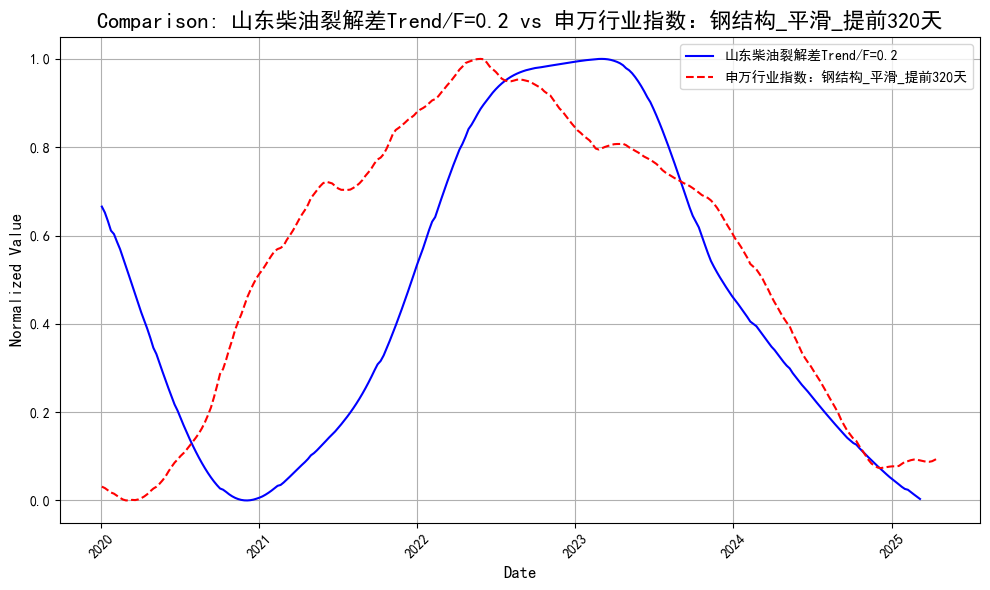

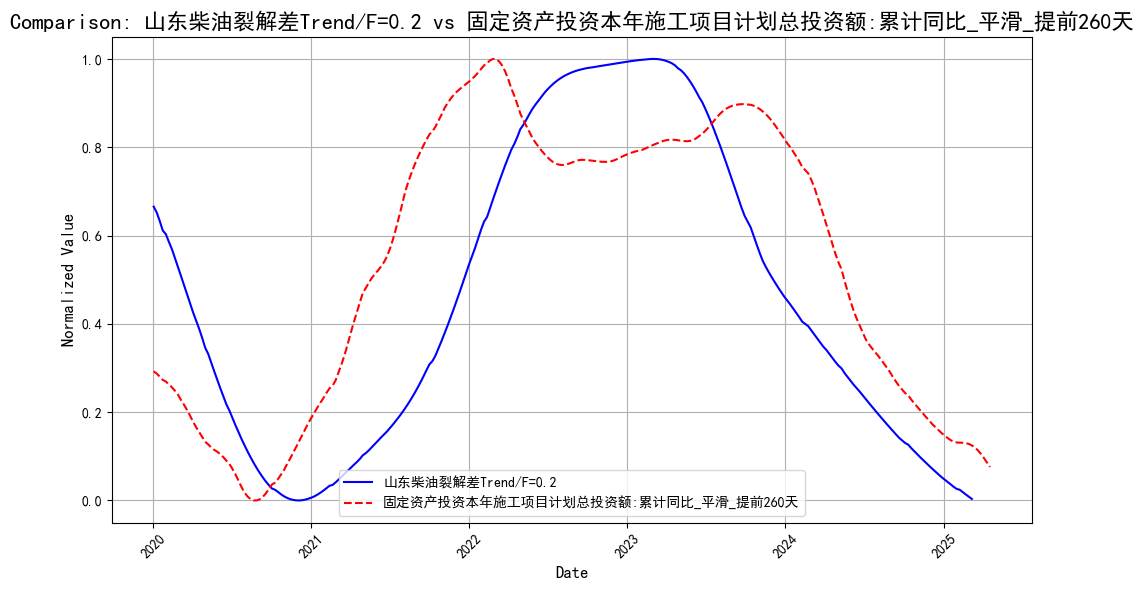

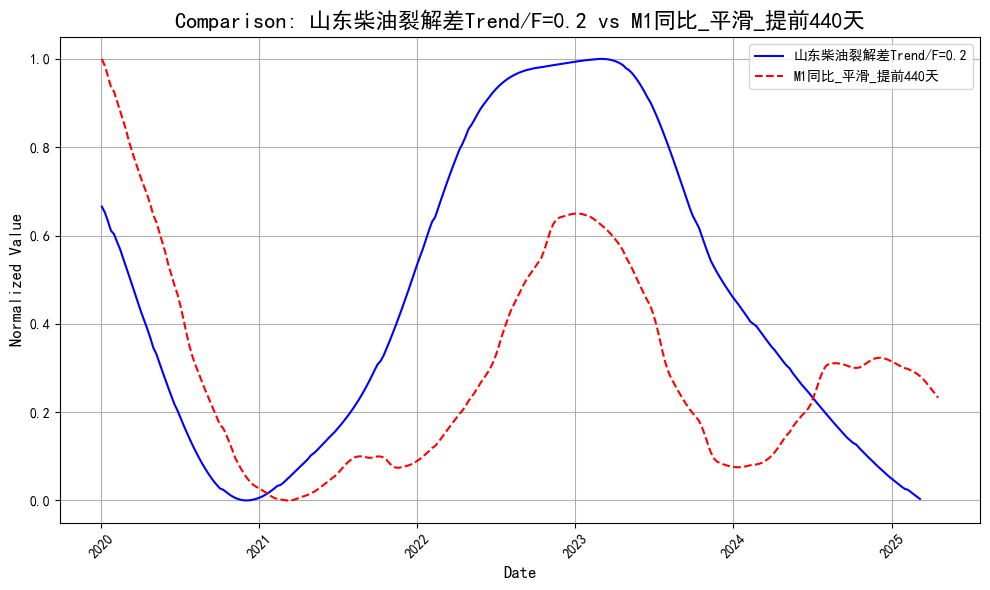

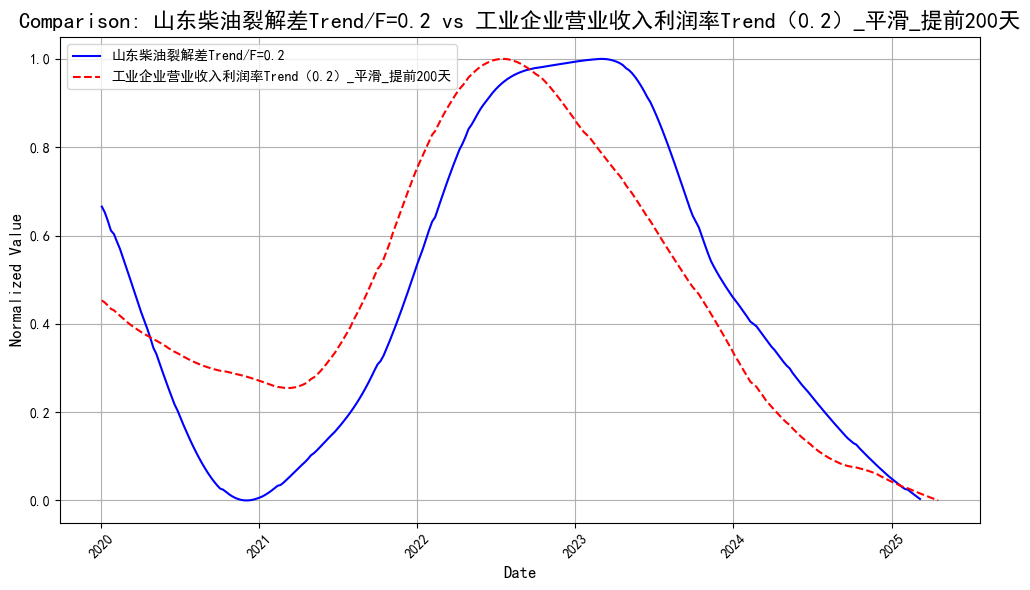

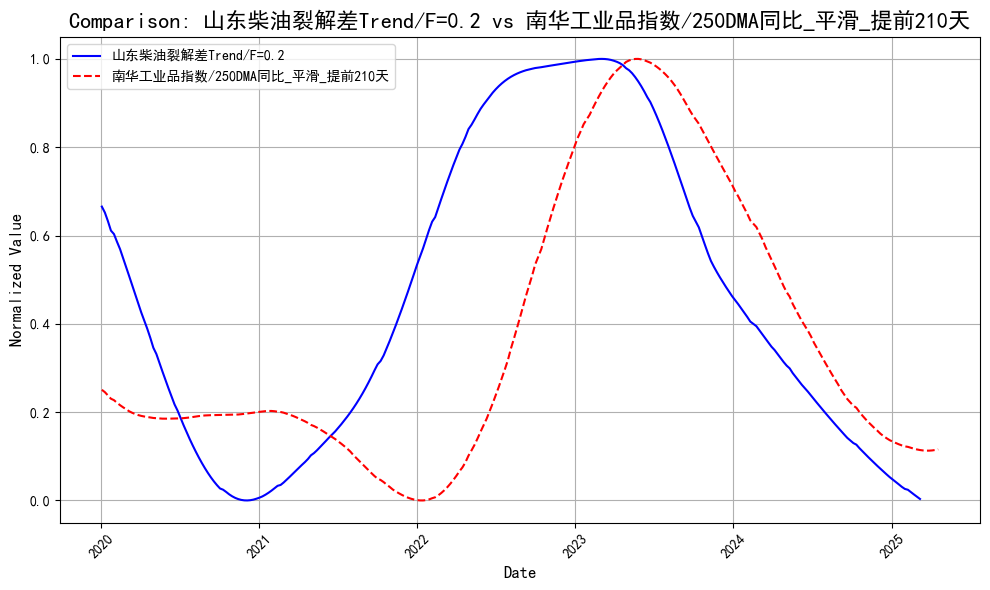

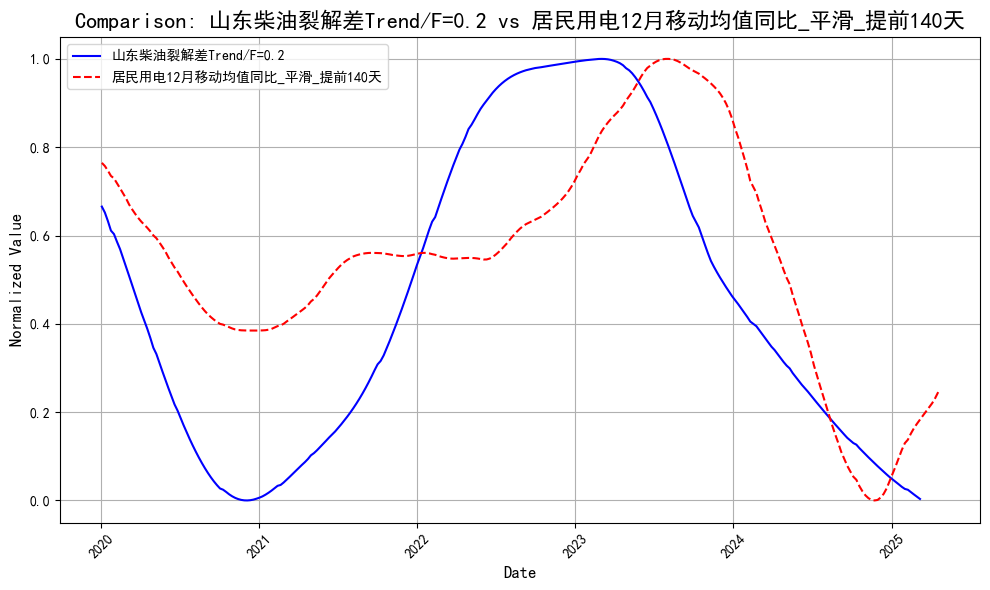

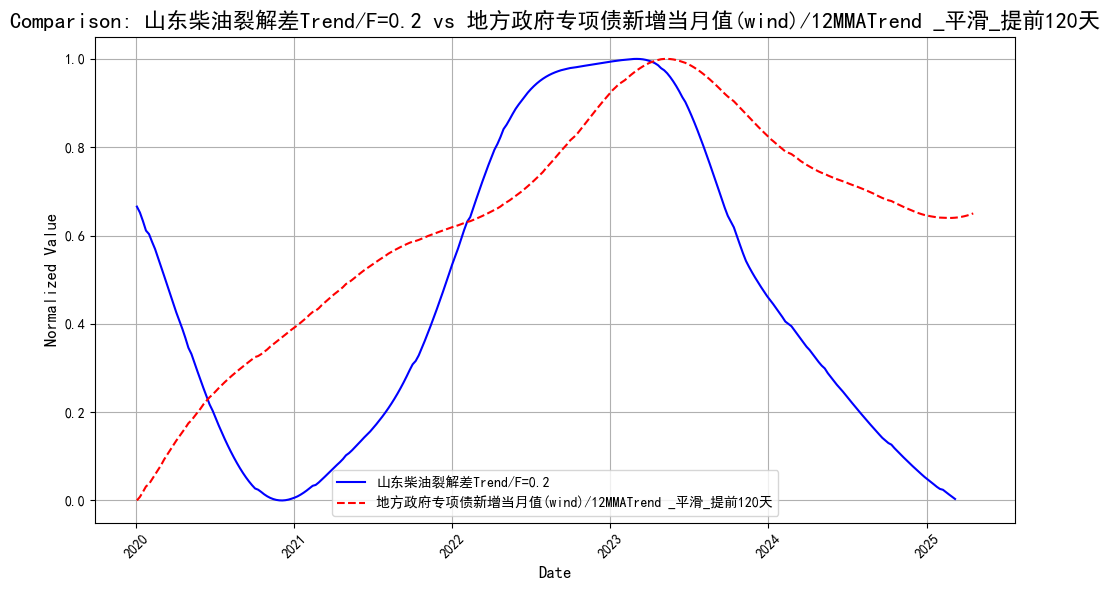

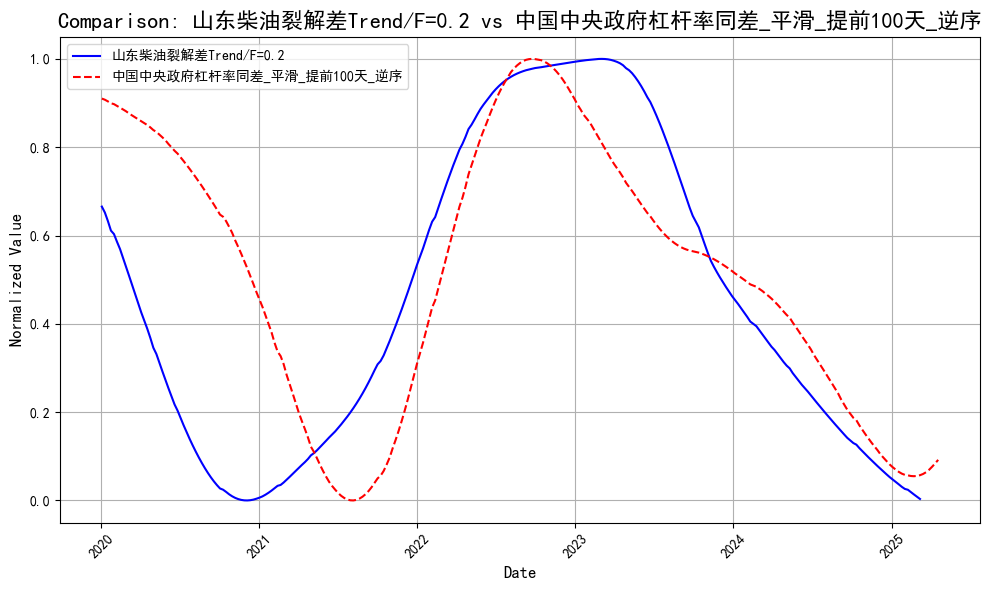

In [10]:
sheet_daily_plot = weekly_data.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东柴油裂解差Trend/F=0.2', 
    compare_cols=[
       '申万行业指数：钢结构_平滑_提前320天',
       '固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天', 
       'M1同比_平滑_提前440天',
       '工业企业营业收入利润率Trend（0.2）_平滑_提前200天', 
       '南华工业品指数/250DMA同比_平滑_提前210天',
       '居民用电12月移动均值同比_平滑_提前140天', 
       '地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天',
       '中国中央政府杠杆率同差_平滑_提前100天_逆序'
        ]
)

线性回归系数：斜率 = -1.753639, 截距 = 266.892677


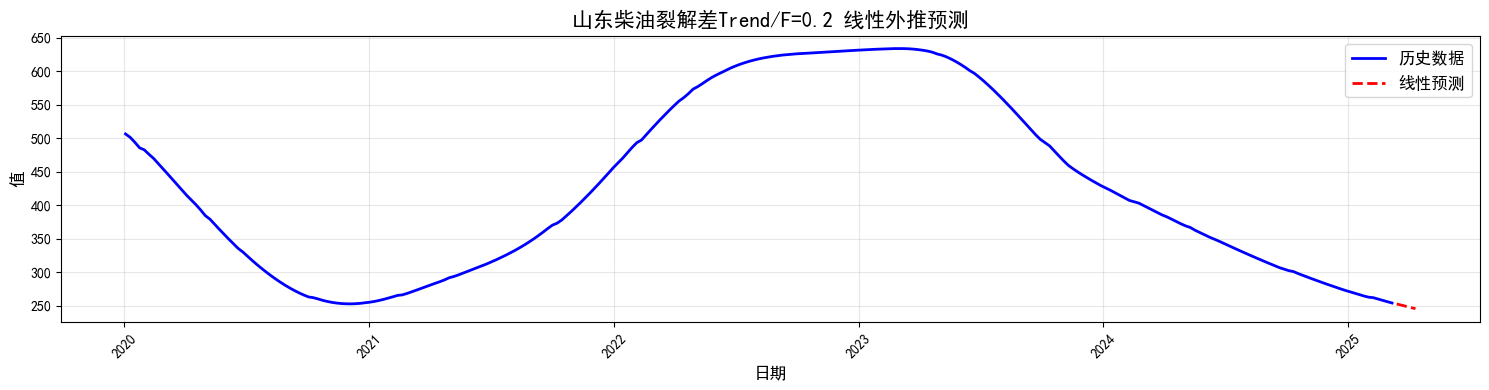

In [11]:
# 准备训练数据（使用最后30个非空值）
train_data = weekly_data[weekly_data['Date'] <= last_day][[target_column]].dropna().tail(8)
train_dates = train_data.index

# 线性回归拟合
x = np.arange(len(train_data))
y = train_data[target_column].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

print(f"线性回归系数：斜率 = {z[0]:.6f}, 截距 = {z[1]:.6f}")

# 预测未来5周
forecast_periods = 5
future_indices = np.arange(len(train_data), len(train_data) + forecast_periods)

# 生成未来日期（每周五）
future_dates = pd.date_range(start=last_day + pd.Timedelta(days=7), periods=forecast_periods, freq='W-FRI')
# 生成预测值
predictions = pd.DataFrame({'Date': future_dates,
                            f'{target_column}_预测': p(future_indices)})
# 合并历史数据和预测结果用于绘图
plot_data = pd.concat([weekly_data[['Date', target_column]],predictions.rename(columns={f'{target_column}_预测': target_column})]).set_index('Date')


plt.figure(figsize=(15, 4))
# 绘制历史数据
plt.plot(plot_data.index[plot_data.index <= last_day], plot_data[plot_data.index <= last_day][target_column], 'b-', label='历史数据', linewidth=2)
# 绘制预测数据
plt.plot(predictions['Date'], predictions[f'{target_column}_预测'], 'r--', label='线性预测', linewidth=2)
plt.title(f'{target_column} 线性外推预测', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('值', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
weekly_data

,Date,山东柴油裂解差Trend/F=0.2,山东柴油裂解差,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,...,地方政府专项债新增当月值(wind)/12MMATrend _平滑,中国中央政府杠杆率同差_平滑_提前100天,申万行业指数：钢结构_平滑_提前320天,固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天,M1同比_平滑_提前440天,工业企业营业收入利润率Trend（0.2）_平滑_提前200天,南华工业品指数/250DMA同比_平滑_提前210天,居民用电12月移动均值同比_平滑_提前140天,地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天,中国中央政府杠杆率同差_平滑_提前100天_逆序
0,2020-01-03,506.563512,15.07585,0.714286,1840.230,5.276829,4.033333,5.796148,0.075400,0.057275,...,1762.134190,0.329405,1810.377389,6.262016,12.345132,6.055410,0.089804,0.094602,1077.957700,-0.329405
1,2020-01-10,501.443316,50.75814,0.747619,1894.194,4.756098,3.177778,5.794220,0.078100,0.055117,...,1776.965429,0.337086,1803.094933,6.216162,12.187447,6.048272,0.087772,0.093712,1100.980348,-0.337086
2,2020-01-17,494.068426,160.75024,0.795238,1944.804,4.012195,1.955556,5.791465,0.081500,0.052033,...,1797.644306,0.348220,1792.293128,6.151932,11.963878,6.038188,0.084977,0.092417,1133.479197,-0.348220
3,2020-01-24,485.868348,176.61015,0.847619,1998.355,3.193902,0.611111,5.788434,0.083925,0.048642,...,1819.612114,0.360698,1780.885653,6.082691,11.726460,6.027333,0.082103,0.090957,1168.634672,-0.360698
4,2020-01-31,482.864518,188.01595,0.871429,1893.290,2.821951,0.000000,5.787056,0.084425,0.047100,...,1829.332246,0.366448,1774.914722,6.051699,11.620295,6.022529,0.080863,0.090282,1184.390813,-0.366448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2025-03-21,NaN,NaN,1.800000,2274.990,4.000000,0.400000,5.346815,0.013200,0.064700,...,3245.128678,2.821243,1935.906589,4.610584,5.161362,5.406548,0.037286,0.025124,2915.132182,-2.821243
273,2025-03-28,NaN,NaN,1.800000,2274.990,4.000000,0.400000,5.346815,0.013200,0.064700,...,3261.048692,2.804974,1935.423244,4.537269,5.078728,5.402645,0.037293,0.026224,2919.187881,-2.804974
274,2025-04-04,NaN,NaN,1.800000,2274.990,4.000000,0.400000,5.346815,0.013200,0.064700,...,3276.400297,2.784753,1938.542633,4.449922,4.993188,5.398788,0.037482,0.027413,2924.273040,-2.784753
275,2025-04-11,NaN,NaN,1.800000,2274.990,4.000000,0.400000,5.346815,0.013200,0.064700,...,3291.183493,2.762531,1946.250767,4.354211,4.906968,5.394984,0.037850,0.028835,2930.438552,-2.762531


In [13]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
weekly_data = weekly_data.set_index('Date')
weekly_data.index = pd.date_range(start=weekly_data.index.min(), periods=len(weekly_data), freq='W-FRI')

train_data = weekly_data[weekly_data.index <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = weekly_data[weekly_data.index  > last_day].copy()

feature_columns = [
       '申万行业指数：钢结构_平滑_提前320天',
       '固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天', 
       'M1同比_平滑_提前440天',
       '工业企业营业收入利润率Trend（0.2）_平滑_提前200天', 
       '南华工业品指数/250DMA同比_平滑_提前210天',
       '居民用电12月移动均值同比_平滑_提前140天', 
       '地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天',
       '中国中央政府杠杆率同差_平滑_提前100天_逆序'
]

predict_column = '山东柴油裂解差Trend/F=0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np

def find_best_arimax_params(y_train, X_train, p_range=(0,3), d_range=(0,2), q_range=(0,3), maxiter=200):
    best_aic = np.inf
    best_params = None
    best_model = None

    for p, d, q in itertools.product(range(*p_range), range(*d_range), range(*q_range)):
        try:
            model = SARIMAX(
                y_train, 
                exog=X_train,
                order=(p, d, q),
                enforce_stationarity=False, 
                enforce_invertibility=False
            )
            result = model.fit(disp=0, maxiter=maxiter, method='lbfgs')

            if result.aic < best_aic:
                best_aic = result.aic
                best_params = (p, d, q)
                best_model = result

            print(f"ARIMAX({p},{d},{q}) - AIC: {result.aic:.2f}")

        except Exception as e:
            print(f"ARIMAX({p},{d},{q}) failed: {e}")
            continue

    if best_model is None:
        raise ValueError("No valid ARIMAX model found. Check the data or expand the search space.")

    return best_params, best_model

# 调用优化后的函数
print("正在寻找最优ARIMAX参数...")
best_params, best_model = find_best_arimax_params(y_train, X_train)
print(f"最优ARIMAX参数 (p,d,q): {best_params}")
print(best_model.summary())


正在寻找最优ARIMAX参数...
ARIMAX(0,0,0) - AIC: 2070.08


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(0,0,1) - AIC: 1715.70
ARIMAX(0,0,2) - AIC: 1402.53
ARIMAX(0,1,0) - AIC: 935.52
ARIMAX(0,1,1) - AIC: 685.37
ARIMAX(0,1,2) - AIC: 577.16


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(1,0,0) - AIC: 1022.61


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(1,0,1) - AIC: 772.32
ARIMAX(1,0,2) - AIC: 659.59


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(1,1,0) - AIC: 352.25
ARIMAX(1,1,1) - AIC: 348.59


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(1,1,2) - AIC: 348.75
ARIMAX(2,0,0) - AIC: 525.25


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(2,0,1) - AIC: 461.31


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX(2,0,2) - AIC: 476.98
ARIMAX(2,1,0) - AIC: 348.54
ARIMAX(2,1,1) - AIC: 357.71
ARIMAX(2,1,2) - AIC: 342.62
最优ARIMAX参数 (p,d,q): (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:     山东柴油裂解差Trend/F=0.2   No. Observations:                  261
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -158.308
Date:                Tue, 11 Mar 2025   AIC                            342.616
Time:                        15:45:37   BIC                            388.754
Sample:                    01-03-2020   HQIC                           361.170
                         - 12-27-2024                                         
Covariance Type:                  opg                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
申万行业指数：钢

In [15]:
# 4. 在测试集上进行回测
y_train_pred = best_model.forecast(steps=len(y_train), exog=X_train)
y_test_pred = best_model.forecast(steps=len(test_data), exog=X_test)

# 5. 预测未来4周
future_steps = min(4, len(future_data))
y_future_pred = best_model.forecast(steps=future_steps, exog=X_future[:future_steps])

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

# 6. 使用全部历史数据重新训练模型
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

full_model = SARIMAX(
    y_all,
    exog=X_all,
    order=best_params,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_results = full_model.fit(disp=False)
y_future_pred_all = full_results.forecast(steps=future_steps, exog=X_future[:future_steps])

# 7. 计算评估指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 RMSE: {train_rmse:.4f}")
print(f"测试集 RMSE: {test_rmse:.4f}")
print(f"训练集 R²: {train_r2:.4f}")
print(f"测试集 R²: {test_r2:.4f}")

# 存储全部数据的预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

训练集 RMSE: 51.7425
测试集 RMSE: 0.7704
训练集 R²: 0.8441
测试集 R²: 0.9782


c:\Users\hzins\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


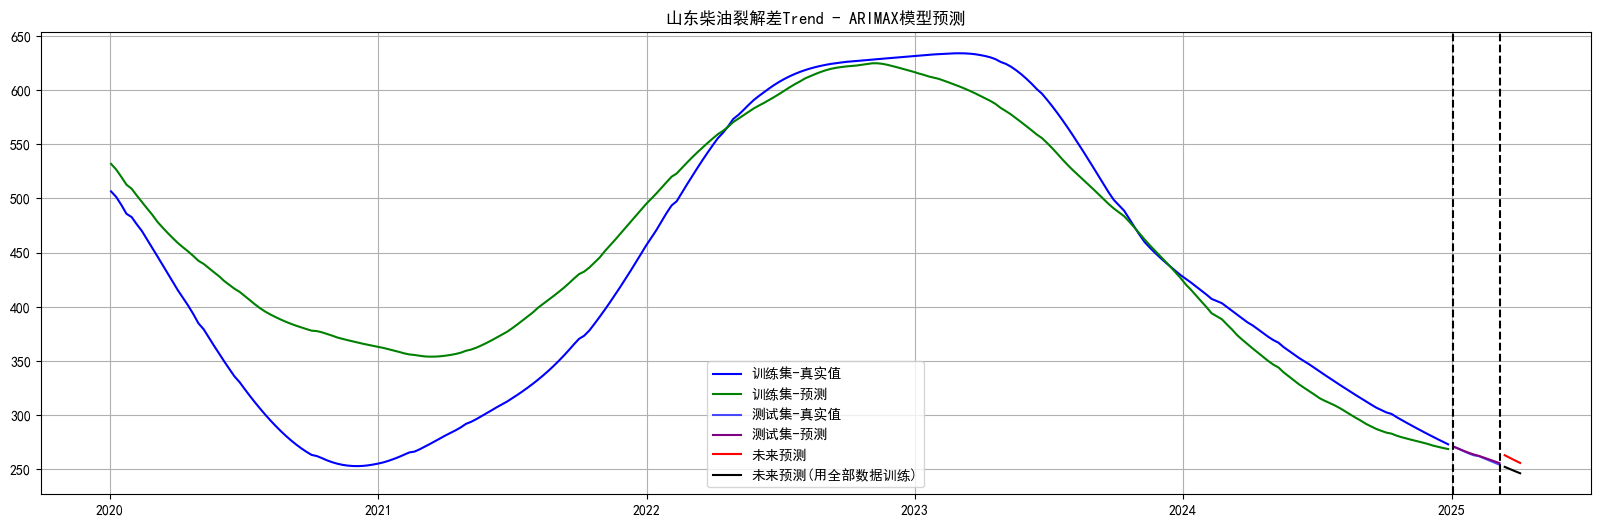

In [16]:
# 8. 可视化结果
plt.figure(figsize=(20, 6))

# 绘制训练集
plt.plot(train_data.index, y_train, label='训练集-真实值', color='blue')
plt.plot(train_data.index, y_train_pred, label='训练集-预测', color='green')

# 绘制测试集和预测
plt.plot(test_data.index, y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.index, y_test_pred, label='测试集-预测', color='purple')

# 绘制未来预测
future_dates = future_data.index[:future_steps]
plt.plot(future_dates, y_future_pred, label='未来预测', color='red')
plt.plot(future_dates, y_future_pred_all, label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data.index[0], color='black', linestyle='--')
plt.axvline(x=last_day, color='black', linestyle='--')

# 设置标题和图例
plt.title('山东柴油裂解差Trend - ARIMAX模型预测')
plt.legend()
plt.grid(True)
plt.show()

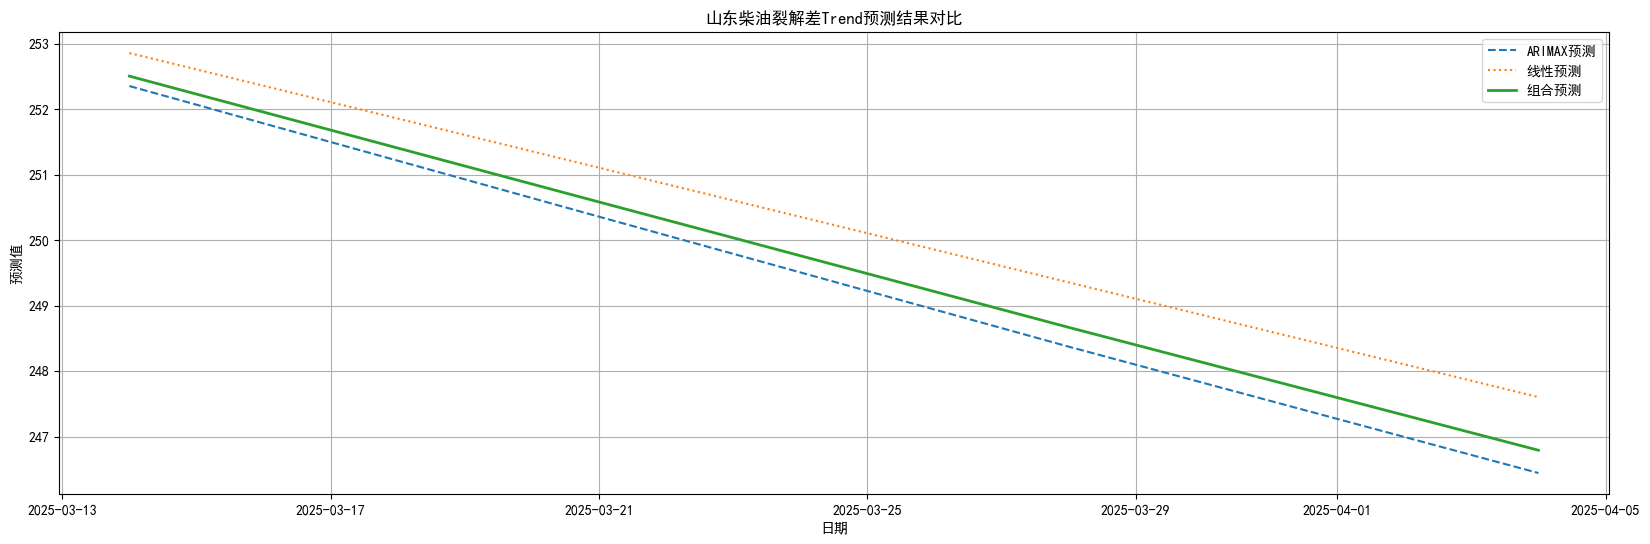

In [17]:
#-------------------------------------------------------------------------
# 组合模型部分
#-------------------------------------------------------------------------
# 创建一个包含预测结果的DataFrame
predictions_arimax = pd.DataFrame({
    'Date': future_dates,
    f'{target_column}_ARIMAX预测': y_future_pred_all
}).reset_index(drop=True)

# 创建线性预测结果DataFrame
predictions_linear = predictions

# 确保两个预测结果的日期对齐
predictions_arimax['Date'] = pd.to_datetime(predictions_arimax['Date'])
predictions_linear['Date'] = pd.to_datetime(predictions_linear['Date'])

# 合并两个预测结果
predictions_merged = pd.merge(predictions_arimax, predictions_linear, on='Date', how='inner')
# 计算组合预测值 - 使用指数加权移动平均组合
alpha = 0.7  # 指数权重参数
predictions_merged[f'{target_column}_组合预测'] = (
    alpha * predictions_merged[f'{target_column}_ARIMAX预测'] + 
    (1-alpha) * predictions_merged[f'{target_column}_预测']
)
# 最终结果
predictions_combined = predictions_merged[['Date', f'{target_column}_组合预测']]


# 绘制组合预测结果图
plt.figure(figsize=(20, 6))

# 绘制ARIMAX预测结果
plt.plot(predictions_merged['Date'], 
         predictions_merged[f'{target_column}_ARIMAX预测'],
         label='ARIMAX预测', 
         linestyle='--')

# 绘制线性预测结果  
plt.plot(predictions_merged['Date'],
         predictions_merged[f'{target_column}_预测'],
         label='线性预测',
         linestyle=':')

# 绘制组合预测结果
plt.plot(predictions_merged['Date'],
         predictions_merged[f'{target_column}_组合预测'],
         label='组合预测',
         linewidth=2)

plt.title('山东柴油裂解差Trend预测结果对比')
plt.xlabel('日期')
plt.ylabel('预测值')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
predictions_combined

,Date,山东柴油裂解差Trend/F=0.2_组合预测
0,2025-03-14,252.510100
1,2025-03-21,250.585514
2,2025-03-28,248.668214
3,2025-04-04,246.789971


---

In [19]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/山东柴油裂解差Non-Trend—F0.2_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    predictions_combined[['Date', '山东柴油裂解差Trend/F=0.2_组合预测']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()
# 计算最终的
merged_df['山东柴油裂解差'] = merged_df['预测值'] + merged_df['山东柴油裂解差Trend/F=0.2_组合预测']
merged_df.head() 

,Date,预测值,山东柴油裂解差Trend/F=0.2_组合预测,山东柴油裂解差
563,2025-03-14,451.3926,252.510100,703.902700
568,2025-03-21,349.6984,250.585514,600.283914
573,2025-03-28,357.4353,248.668214,606.103514
578,2025-04-04,371.6161,246.789971,618.406071


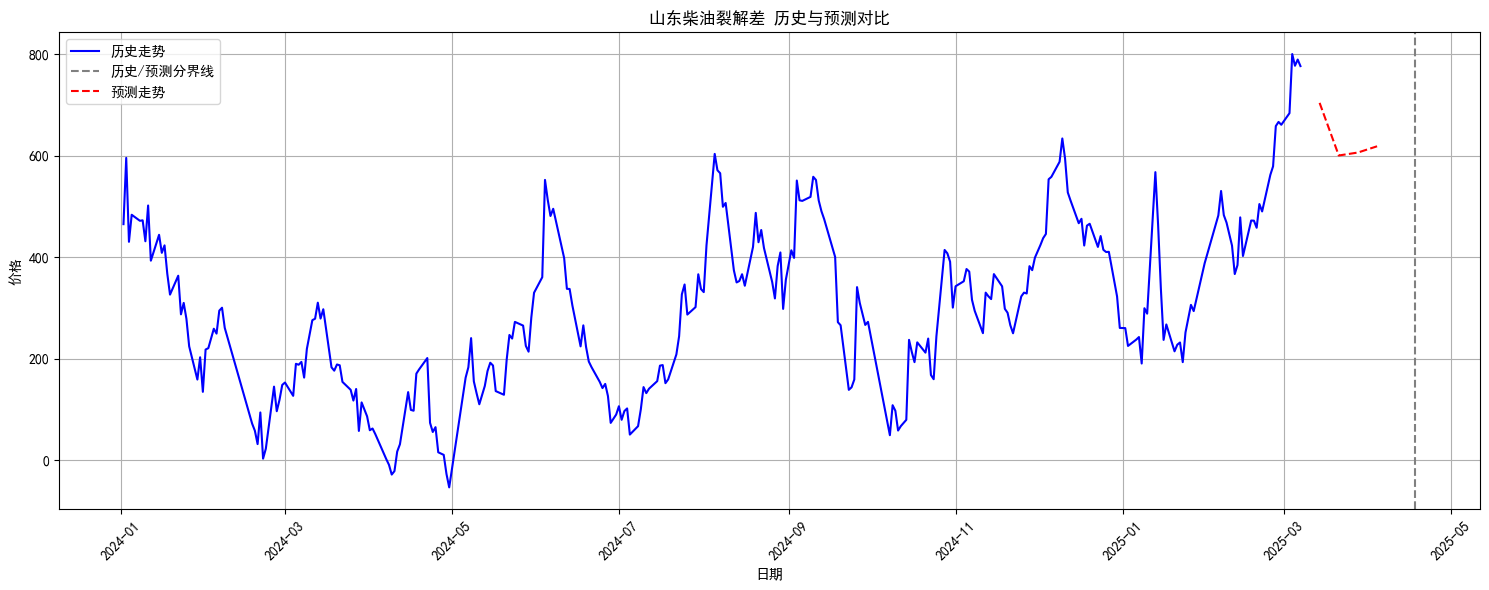

In [20]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
# 将sheet的索引转换为Date列
sheet = sheet.reset_index()
sheet = sheet.rename(columns={'index':'Date'})
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['山东柴油裂解差'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['山东柴油裂解差'], label='预测走势', color='red', linestyle='--')

plt.title('山东柴油裂解差 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '山东柴油裂解差']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '山东柴油裂解差']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
future_mask = merged_df_shizhi['Date'] > last_day
merged_df_shizhi.loc[future_mask, '山东柴油裂解差'] = merged_df_shizhi.loc[future_mask, '山东柴油裂解差'].interpolate(method='linear')
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/山东柴油裂解差_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,山东柴油裂解差
580,2025/04/18,NaN,NaN
579,2025/04/17,NaN,NaN
578,2025/04/16,NaN,NaN
577,2025/04/15,NaN,NaN
576,2025/04/14,NaN,NaN
...,...,...,...
4,2023/01/09,771.0289,NaN
3,2023/01/06,707.9450,NaN
2,2023/01/05,717.9453,NaN
1,2023/01/04,634.5979,NaN


In [22]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/山东柴油裂解差_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,山东柴油裂解差
0,2025/04/30,NaN,618.406071
1,2025/03/31,776.3352,608.564025
2,2025/02/28,660.7536,NaN
3,2025/01/31,388.0224,NaN
4,2024/12/31,260.6402,NaN


---

In [23]:
last_day

Timestamp('2025-03-07 00:00:00')

In [24]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '山东柴油裂解差Trend/F=0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, predictions_combined, on='Date', how='outer')
# 获取last_day之后的数据
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
future_mask = merged_df_trend['Date'] > last_day
merged_df_trend.loc[future_mask, '山东柴油裂解差Trend/F=0.2_组合预测'] = merged_df_trend.loc[future_mask, '山东柴油裂解差Trend/F=0.2_组合预测'].interpolate(method='linear')
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/山东柴油裂解差Trend-F=0.2_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,山东柴油裂解差Trend/F=0.2_组合预测
580,2025/04/18,NaN,NaN
579,2025/04/17,NaN,NaN
578,2025/04/16,NaN,NaN
577,2025/04/15,NaN,NaN
576,2025/04/14,NaN,NaN
...,...,...,...
4,2023/01/09,632.115084,NaN
3,2023/01/06,632.030198,NaN
2,2023/01/05,631.944850,NaN
1,2023/01/04,631.859106,NaN


In [25]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/山东柴油裂解差Trend-F=0.2_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_trend.head()

,Date,实际值,山东柴油裂解差Trend/F=0.2_组合预测
0,2025/04/30,NaN,246.789971
1,2025/03/31,253.572217,248.292565
2,2025/02/28,255.479248,NaN
3,2025/01/31,262.898085,NaN
4,2024/12/31,271.350617,NaN
